In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import matplotlib
from sklearn.neighbors import KernelDensity
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from overscan_subtraction import overscan_subtraction
from statsmodels.regression.linear_model import OLS

# 1)
Start a Jupyter notebook that will contain all sort of things you will learn in the course of your data analysis. Keep here your procedures that you run so that you can quickly re-run them with a few keystrokes. Also keep here anything you’d keep in a paper logbook regarding notes about your reduction. Markdown in your Jupyter notebook will take the place of formal reduction notes. The quality of the this file will make up one component of the grade for this homework.

In [2]:
############ USER DEFINED VALUES ##################################
imagedir='/Users/dabbiecm/Imaging/'
biasname='a100.fits'
biasnames=['a'+str(i).zfill(3)+'.fits' for i in range(93,112)]
flatname='a048.fits'
flatnames=['a'+str(i).zfill(3)+'.fits' for i in [5,6,7,8,9,10]]
darkname='d001.fits'
darknames=['d'+str(i).zfill(3)+'.fits' for i in range(1,16)]
sciencenames=['a'+str(i).zfill(3)+'.fits' for i in range(11,63)]

bias_vmin=620              # minimum level for plotting bias and dark values
bias_vmax=700              # maximum level for plotting bias and dark values
flat_vmin=28000            # minimum level for plotting flat values
flat_vmax=32000            # maximum level for plotting flat values
dark_vmin=625
dark_vmax=700

left_overscan=[0,54]       # columns of overscan region on left side (indexed from 0) (last column not included)
right_overscan=[2100,2199] # columns of overscan region on right side (indexed from 0) (last column not included)
trimsec=[54,2100]          # columns of image (last column not included, for pythonic array indexing)

num_bias=len(biasnames)
num_flats=len(flatnames)
num_science=len(sciencenames)
num_darks=len(darknames)
num_rows=2048
num_columns_all=2200

# 2)
Examine the images in DS9 to become familiar with where the overscan region of the chip is (on both sides of the data section; make note of where this is). Look at examples of bias images, dark images, and flats so that you can know by inspection what
kind of image you are viewing.


From log.txt in Imaging/
- a093-a111 -> bias
- d01-d15 -> darks
- a005-a010 -> SkyFlats


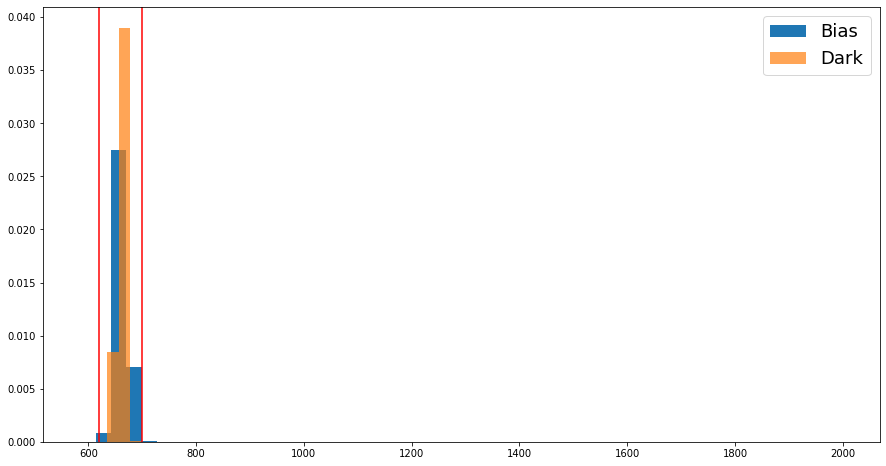

In [3]:
bias=fits.open(imagedir+biasname)[0].data
flat=fits.open(imagedir+flatname)[0].data
dark=fits.open(imagedir+darkname)[0].data

# Show levels of each image
bias_hist=np.asarray(bias).flatten()
flat_hist=np.asarray(flat).flatten()
dark_hist=np.asarray(dark).flatten()

plt.hist(bias_hist,bins=50,density=True,label='Bias')
plt.hist(dark_hist,bins=50,density=True,label='Dark',alpha=0.7)
plt.axvline(bias_vmin,c='r')
plt.axvline(bias_vmax,c='r')
plt.legend(loc='best',fontsize=18)
plt.show()

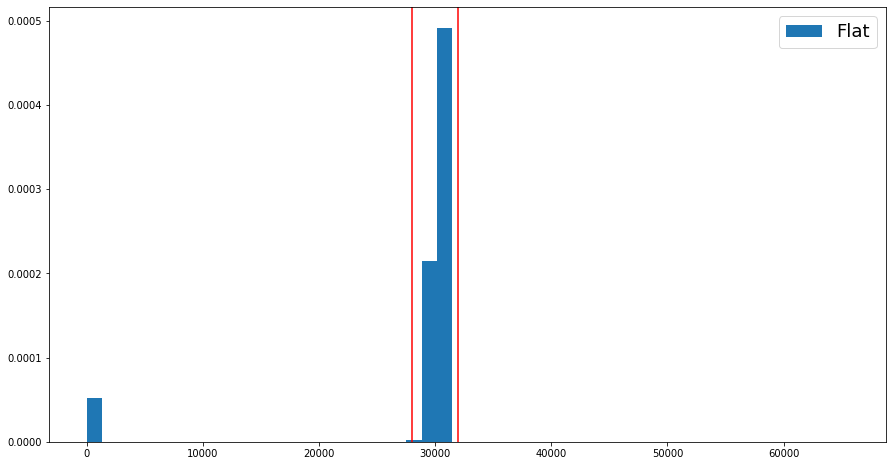

In [4]:
plt.hist(flat_hist,bins=50,density=True,label='Flat')
plt.axvline(flat_vmin,c='r')
plt.axvline(flat_vmax,c='r')
plt.legend(loc='best',fontsize=18)
plt.show()

#### Flat levels near 0 should be overscan region

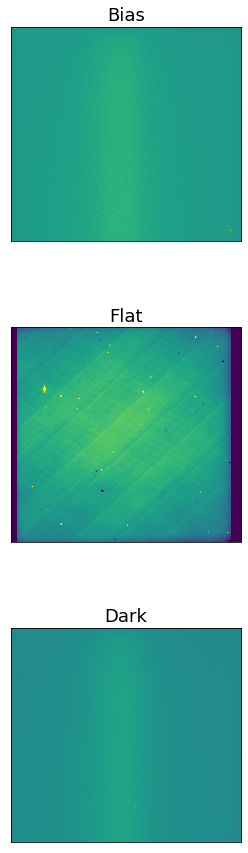

In [5]:
# Open and display images in python
fig,axs=plt.subplots(3,1,figsize=(15,15))
# Show bias
axs[0].imshow(bias,vmin=bias_vmin,vmax=bias_vmax)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Bias',fontsize=18)
# Show Flat
axs[1].imshow(flat,vmin=flat_vmin,vmax=flat_vmax)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Flat',fontsize=18)
# Show Dark
axs[2].imshow(dark,vmin=bias_vmin,vmax=bias_vmax)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Dark',fontsize=18)
plt.subplots_adjust(wspace=0,hspace=0.4)
plt.grid(False)
plt.show()

#### Let's find the overscan region of the flat

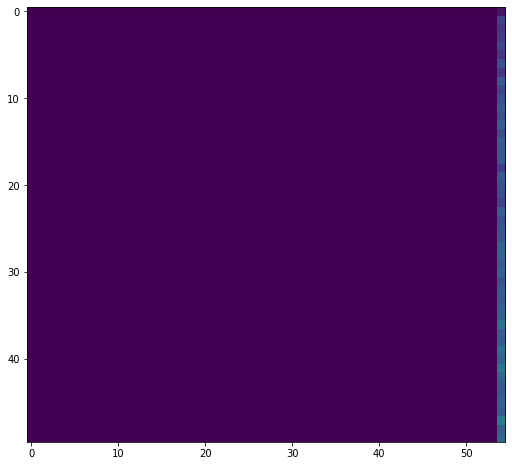

In [6]:
# left side
plt.imshow(flat[:50,:left_overscan[1]+1],vmin=flat_vmin,vmax=flat_vmax)

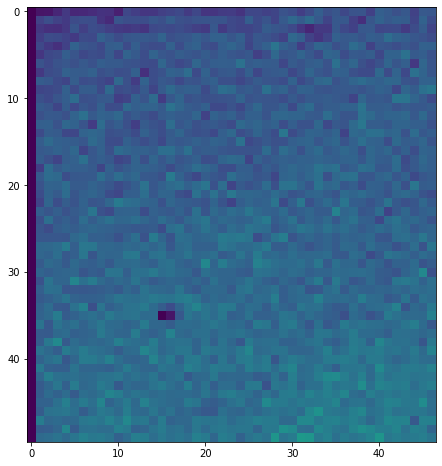

In [7]:
plt.imshow(flat[:50,left_overscan[1]-1:100],vmin=flat_vmin,vmax=flat_vmax)

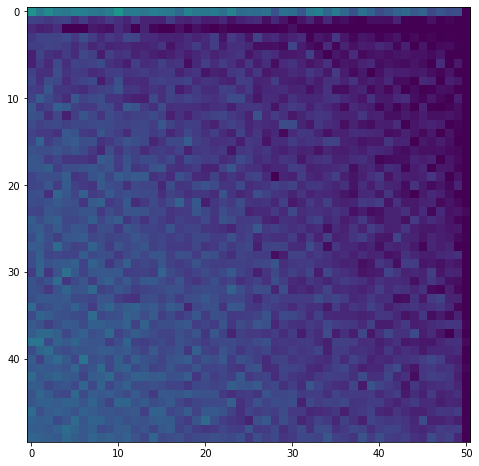

In [8]:
plt.imshow(flat[:50,2050:right_overscan[0]+1],vmin=flat_vmin,vmax=flat_vmax)

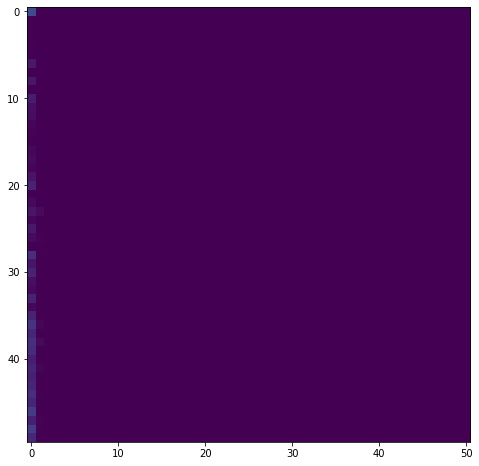

In [9]:
plt.imshow(flat[:50,right_overscan[0]-1:2150],vmin=flat_vmin,vmax=flat_vmax)

In [10]:
print(flat[:,trimsec[0]:trimsec[1]].shape)

(2048, 2046)


# 3)

Assess the RMS and mean levels of an image. Use Python to practice plotting lines and columns of data from one of the bias images. Use Python to compute the mean and RMS of a region near the center of the chip.

In [11]:
RMS_flat=np.std(flat[:,trimsec[0]:trimsec[1]].flatten())
RMS_bias=np.std(bias[:,trimsec[0]:trimsec[1]].flatten())
RMS_dark=np.std(dark[:,trimsec[0]:trimsec[1]].flatten())

print("RMS for full flat image (no overscan): {:.1f}".format(RMS_flat))
print("RMS for full bias image (no overscan): {:.1f}".format(RMS_bias))
print("RMS for full dark image (no overscan): {:.1f}".format(RMS_dark))

RMS for full flat image (no overscan): 545.1
RMS for full bias image (no overscan): 8.9
RMS for full dark image (no overscan): 4.8


In [12]:
mean_flat=np.mean(flat[:,trimsec[0]:trimsec[1]].flatten())
mean_bias=np.mean(bias[:,trimsec[0]:trimsec[1]].flatten())
mean_dark=np.mean(dark[:,trimsec[0]:trimsec[1]].flatten())

print("mean for full flat image (no overscan): {:.1f}".format(mean_flat))
print("mean for full bias image (no overscan): {:.1f}".format(mean_bias))
print("mean for full dark image (no overscan): {:.1f}".format(mean_dark))

mean for full flat image (no overscan): 30316.6
mean for full bias image (no overscan): 665.8
mean for full dark image (no overscan): 660.9


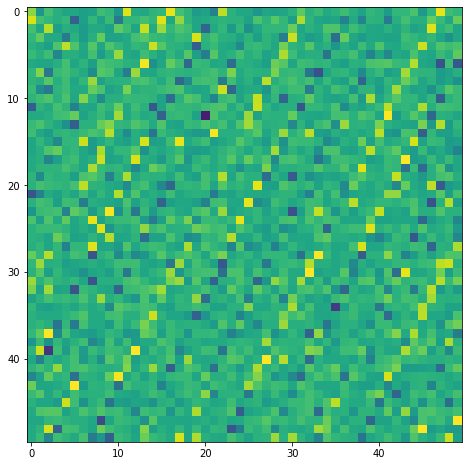

In [13]:
# Region near the center
nrows=bias.shape[0]
ncols=bias.shape[1]

plt.imshow(bias[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)],vmin=bias_vmin,vmax=bias_vmax)

In [14]:
RMS_flat_center=np.std(flat[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)].flatten())
RMS_bias_center=np.std(bias[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)].flatten())
RMS_dark_center=np.std(dark[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)].flatten())

print("RMS for center of flat image: {:.1f}".format(RMS_flat_center))
print("RMS for center of bias image: {:.1f}".format(RMS_bias_center))
print("RMS for center of dark image: {:.1f}".format(RMS_dark_center))

RMS for center of flat image: 184.5
RMS for center of bias image: 8.8
RMS for center of dark image: 4.6


In [15]:
mean_flat_center=np.mean(flat[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)].flatten())
mean_bias_center=np.mean(bias[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)].flatten())
mean_dark_center=np.mean(dark[int(nrows/2-25):int(nrows/2+25),int(ncols/2-25):int(ncols/2+25)].flatten())

print("mean for center of flat image: {:.1f}".format(mean_flat_center))
print("mean for center of bias image: {:.1f}".format(mean_bias_center))
print("mean for center of dark image: {:.1f}".format(mean_dark_center))

mean for center of flat image: 30900.0
mean for center of bias image: 670.9
mean for center of dark image: 666.1


# 5)

Examine the all bias exposures (or overscan regions throughout the night) and quantify how much the bias level changes throughout the night. Compare the mean level of the biases to the mean levels of the overscan regions from other files throughout the night. How much variation do you find? Make an argument for whether it would be a good or bad idea to combine all of the biases to make a master bias and subtract that from all the images versus using the overscan region of each image as an estimate of the bias level.

a093.fits mean=665.8
a093.fits sigma=9.5
a094.fits mean=665.5
a094.fits sigma=8.9
a095.fits mean=665.6
a095.fits sigma=8.9
a096.fits mean=665.7
a096.fits sigma=8.9
a097.fits mean=665.7
a097.fits sigma=9.2
a098.fits mean=665.6
a098.fits sigma=8.9
a099.fits mean=665.6
a099.fits sigma=8.9
a100.fits mean=665.6
a100.fits sigma=8.9
a101.fits mean=665.6
a101.fits sigma=8.9
a102.fits mean=665.5
a102.fits sigma=9.1
a103.fits mean=665.6
a103.fits sigma=9.2
a104.fits mean=665.6
a104.fits sigma=8.9
a105.fits mean=665.5
a105.fits sigma=8.9
a106.fits mean=665.6
a106.fits sigma=9.2
a107.fits mean=665.5
a107.fits sigma=9.0
a108.fits mean=665.6
a108.fits sigma=9.0
a109.fits mean=665.6
a109.fits sigma=8.9
a110.fits mean=665.6
a110.fits sigma=8.9
a111.fits mean=665.6
a111.fits sigma=8.9


Text(0, 0.5, 'Density')

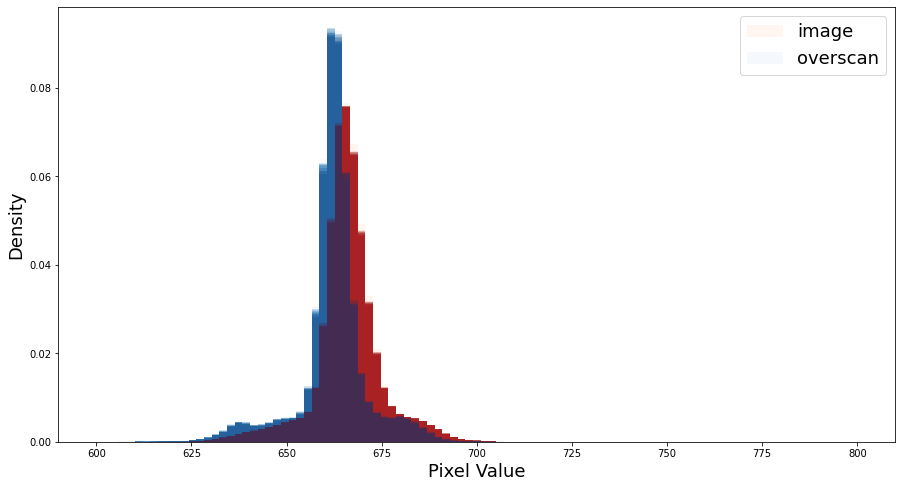

In [16]:
# Does the level change throughout the night?

# separate overscan from image in this cell, print mean, sigma values for both image and overscan
bins=np.linspace(600,800,100)
cmap1 = matplotlib.cm.get_cmap('Reds')
cmap2 = matplotlib.cm.get_cmap('Blues')
count=0
for name in biasnames:
    count+=1
    cmap_val=count/len(biasnames)
    
    bias_iter=fits.open(imagedir+name)[0].data
    bias_image=bias_iter[:,trimsec[0]:trimsec[1]]
    overscan=bias_iter[:,left_overscan[0]:left_overscan[1]]
    if count==1:
        plt.hist(np.asarray(bias_image).flatten(),bins=bins,density=True,alpha=0.5,color=cmap1(cmap_val),label='image')
        plt.hist(np.asarray(overscan).flatten(),bins=bins,density=True,alpha=0.5,color=cmap2(cmap_val),label='overscan')
    else:
        plt.hist(np.asarray(bias_image).flatten(),bins=bins,density=True,alpha=0.2,color=cmap1(cmap_val))
        plt.hist(np.asarray(overscan).flatten(),bins=bins,density=True,alpha=0.2,color=cmap2(cmap_val))
    
    print('{:s} mean={:.1f}'.format(name,np.mean(bias_iter.flatten())))
    print('{:s} sigma={:.1f}'.format(name,np.std(bias_iter.flatten())))
plt.legend(loc='best',fontsize=18)
plt.xlabel('Pixel Value',fontsize=18)
plt.ylabel('Density',fontsize=18)

### The distribution of bias values does not appear to change throughout the night
### There are differences between the image and overscan regions of the bias images
### It would be acceptable to create a master bias from all of the bias images because their levels do not change throughout the night

# 6)

Using CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE, fit and subtract the over- scan region of each image and trim the image to remove the overscan region. In the overscan fitting, try out ’chebychev’, ’legandre’, and ’hermite’, and ’polynomial’ of various orders for the fitting function. Qualitatively try to summarize the differences between the functions (you can also look up and summarize the properties of these types of polynomials, but this is not required). Also try orders 1 through about 8, and make an argument for how large an order is necessary to fit the overscan region.

Using my own overscan subtraction and trimming function found here https://github.com/Collin-Dabbieri/observing_functions

### Is a mean or median column combination preferred?

Text(0, 0.5, 'Counts (Median over Columns)')

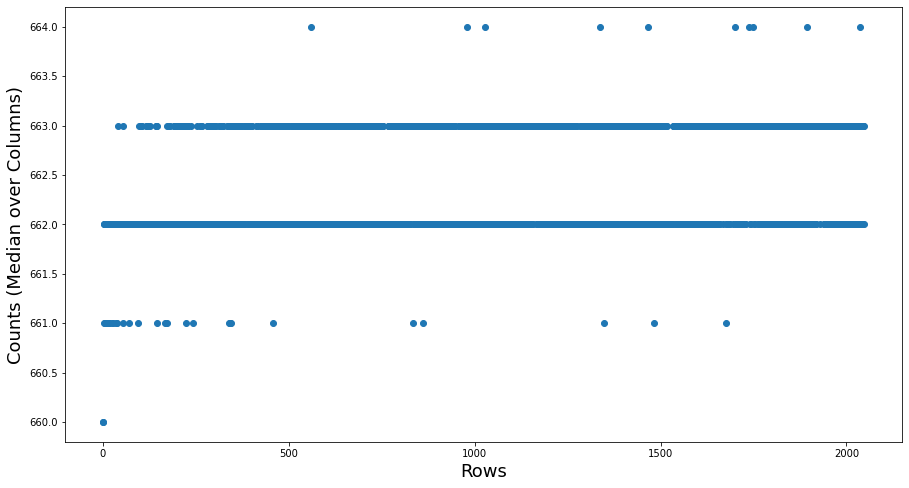

In [17]:
bias_overscan=bias[:,right_overscan[0]:right_overscan[1]]
combine_overscan=np.median(bias_overscan,axis=1)
rows=np.arange(len(combine_overscan))
plt.scatter(rows,combine_overscan)
plt.xlabel('Rows',fontsize=18)
plt.ylabel('Counts (Median over Columns)',fontsize=18)

Text(0, 0.5, 'Counts (Mean over Columns)')

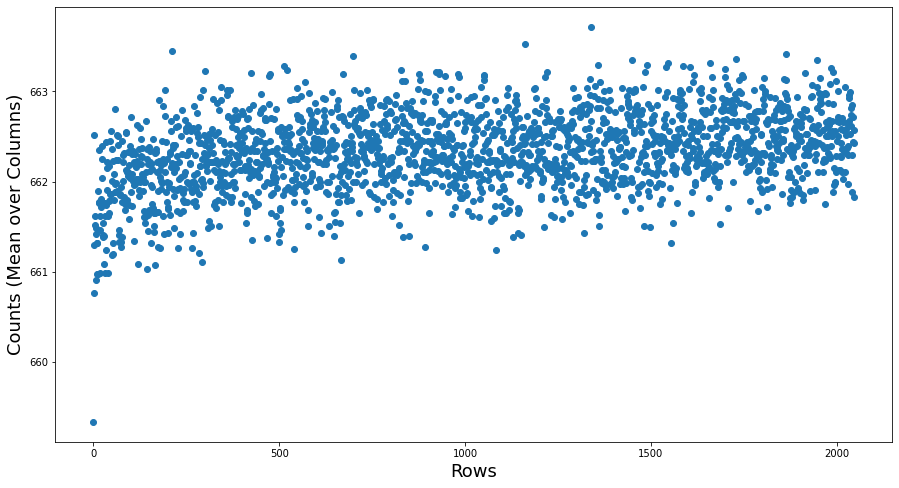

In [18]:
bias_overscan=bias[:,right_overscan[0]:right_overscan[1]]
combine_overscan=np.mean(bias_overscan,axis=1)
rows=np.arange(len(combine_overscan))
plt.scatter(rows,combine_overscan)
plt.xlabel('Rows',fontsize=18)
plt.ylabel('Counts (Mean over Columns)',fontsize=18)

### The mean overscan is preferable

### Now test fitting methods and degrees of fit

AIC for 0 degree polynomial fit: 2280.14
AIC for 1 degree polynomial fit: 2035.16
AIC for 2 degree polynomial fit: 1991.02
AIC for 3 degree polynomial fit: 1946.29
AIC for 4 degree polynomial fit: 1922.60
AIC for 5 degree polynomial fit: 25117.11


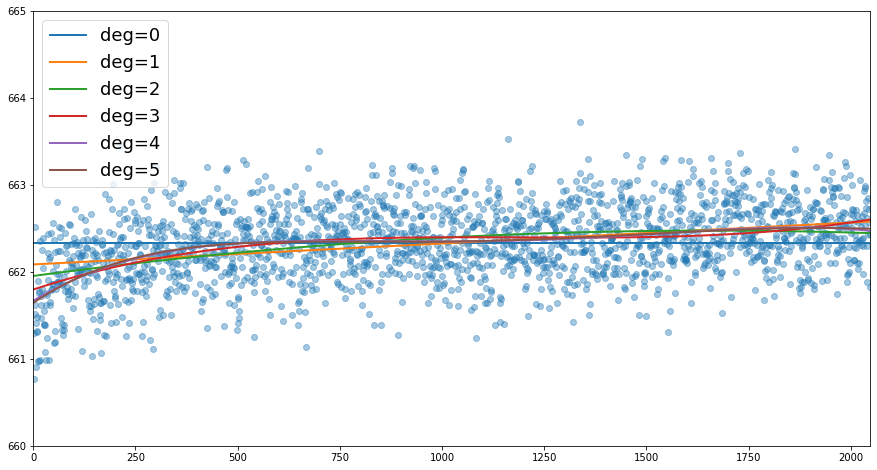

In [19]:
# First Polynomial fits
for fit_deg in [0,1,2,3,4,5]:
     # perform a polynomial fit across the rows of the combined overscan
    p=np.flip(np.polyfit(x=rows,y=combine_overscan,deg=fit_deg)) #flipped so 0 order term is first
    beta=p.reshape((len(p),1))
    # Now create design matrix
    X=np.zeros((len(rows),fit_deg+1))
    for column in range(X.shape[1]):
        X[:,column]=rows**column
    # do some matrix multiplication to get the fit
    fit=np.matmul(X,beta).flatten() # flattened so it's not a column matrix
    
    # AIC calculation to polynomial fit for model selection over fit degree
    regr = OLS(combine_overscan, X).fit()
    AIC=regr.aic
    print("AIC for {:.0f} degree polynomial fit: {:.2f}".format(fit_deg,AIC))
    plt.plot(rows,fit,label='deg='+str(fit_deg),lw=2)
    

plt.axis([0,2048,660,665])
plt.scatter(rows,combine_overscan,alpha=0.4)
plt.legend(loc='best',fontsize=18)
# For the polynomial fit, the AIC prefers degree=4

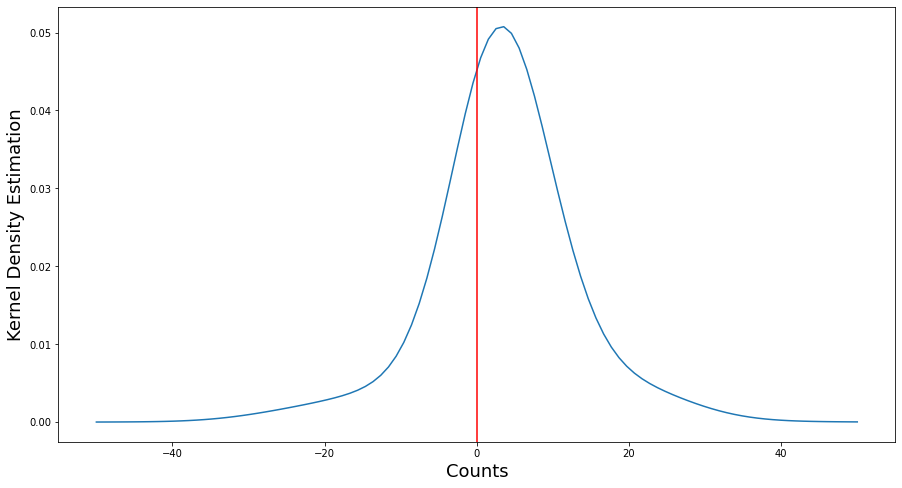

In [20]:
bias_ot,AIC=overscan_subtraction(bias,right_overscan,trimsec,'mean','polynomial',4)
X_plot = np.linspace(-50, 50, 100)[:, np.newaxis]
kde=KernelDensity(kernel='gaussian', bandwidth=5).fit(bias_ot.flatten().reshape(-1,1))
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('Counts',fontsize=18)
plt.ylabel('Kernel Density Estimation',fontsize=18)
plt.axvline(0,c='r')

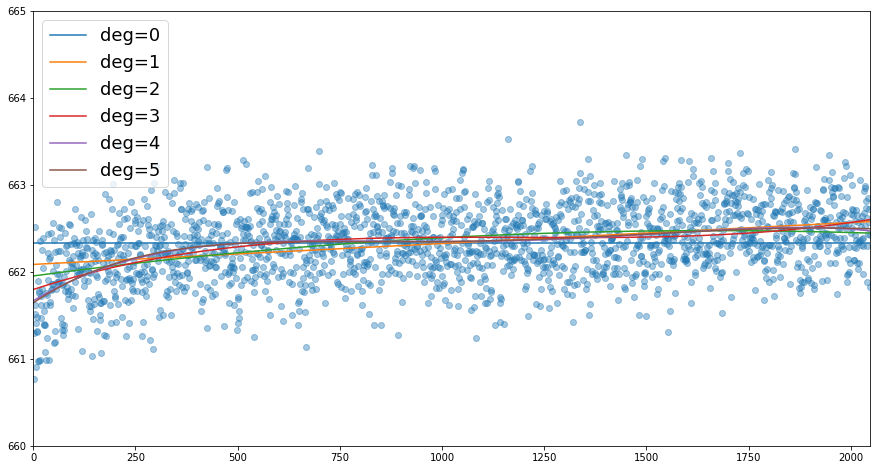

In [21]:
# Now chebychev fits
plt.scatter(rows,combine_overscan,alpha=0.4)
for fit_deg in [0,1,2,3,4,5]:
    p=np.polynomial.chebyshev.Chebyshev.fit(x=rows,y=combine_overscan,deg=fit_deg).convert().coef
    fit=np.polynomial.chebyshev.chebval(x=rows,c=p)
    plt.plot(rows,fit,label='deg='+str(fit_deg))
plt.axis([0,2048,660,665])
plt.legend(loc='best',fontsize=18)

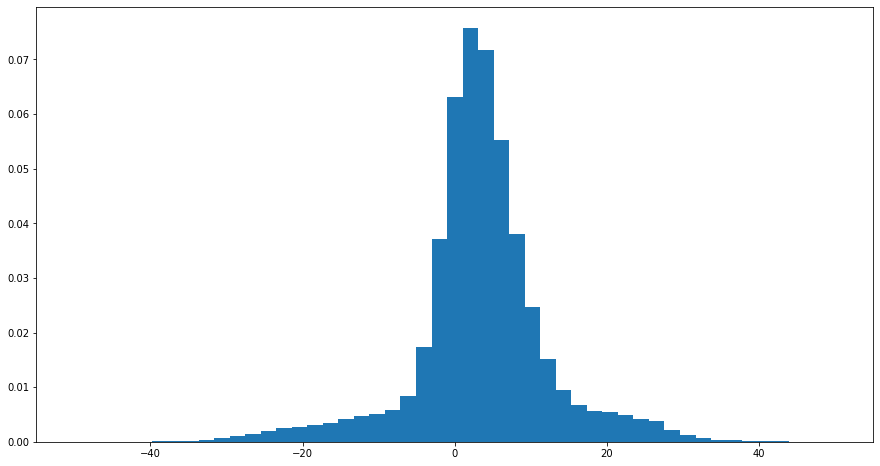

In [24]:
#X_plot = np.linspace(-50, 50, 50)[:, np.newaxis]
#for fit_deg in [0,1,2,3,4,5]:
#    bias_ot=overscan_subtraction(bias,right_overscan,trimsec,'mean','chebychev',fit_deg)
#    kde=KernelDensity(kernel='gaussian', bandwidth=5).fit(bias_ot.flatten().reshape(-1,1))
#    log_dens = kde.score_samples(X_plot)
#    plt.plot(X_plot[:, 0], np.exp(log_dens),label='deg='+str(fit_deg))
#plt.xlabel('Counts',fontsize=18)
#plt.ylabel('Kernel Density Estimation',fontsize=18)
#plt.legend(loc='best',fontsize=18)

bias_ot=overscan_subtraction(bias,right_overscan,trimsec,'mean','chebychev',2)
bins=np.linspace(-50,50,50)
_,_,_=plt.hist(bias_ot.flatten(),bins=bins,density=True)
plt.show()



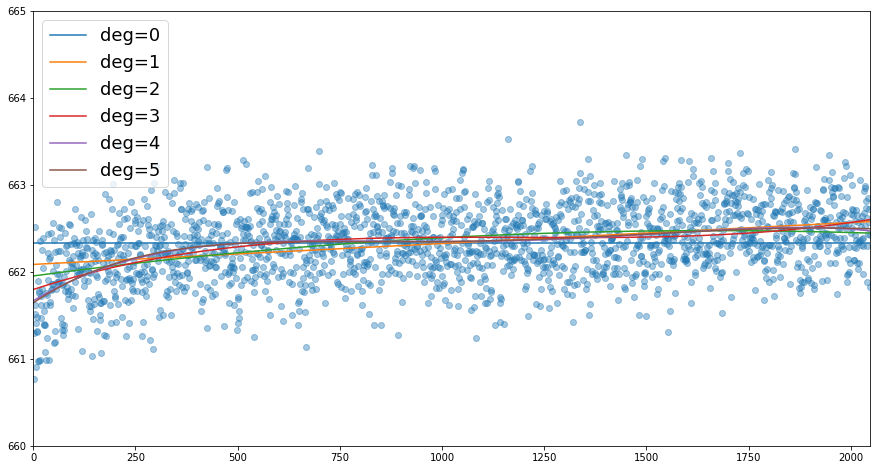

In [25]:
# Now legendre
plt.scatter(rows,combine_overscan,alpha=0.4)
for fit_deg in [0,1,2,3,4,5]:
    p=np.polynomial.legendre.Legendre.fit(x=rows,y=combine_overscan,deg=fit_deg).convert().coef
    fit=np.polynomial.legendre.legval(x=rows,c=p)
    plt.plot(rows,fit,label='deg='+str(fit_deg))
plt.axis([0,2048,660,665])
plt.legend(loc='best',fontsize=18)

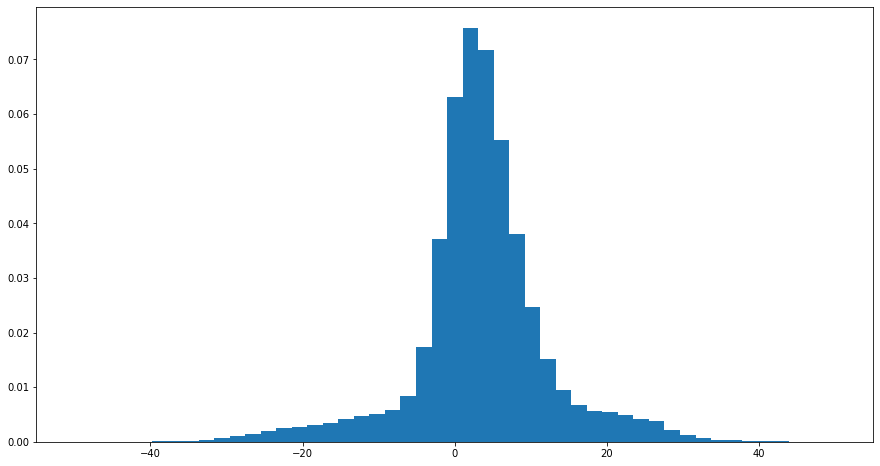

In [26]:
bias_ot=overscan_subtraction(bias,right_overscan,trimsec,'mean','legendre',2)
bins=np.linspace(-50,50,50)
_,_,_=plt.hist(bias_ot.flatten(),bins=bins,density=True)
plt.show()

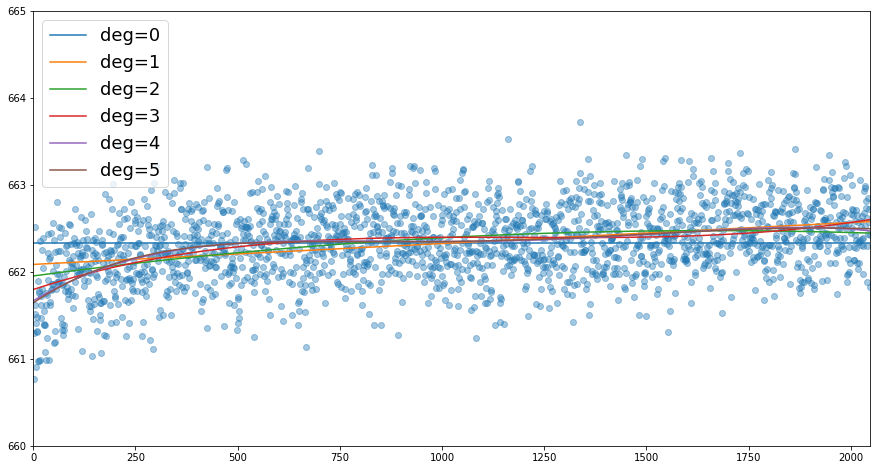

In [27]:
# Now Hermite
plt.scatter(rows,combine_overscan,alpha=0.4)
for fit_deg in [0,1,2,3,4,5]:
    p=np.polynomial.hermite.Hermite.fit(x=rows,y=combine_overscan,deg=fit_deg).convert().coef
    fit=np.polynomial.hermite.hermval(x=rows,c=p)
    plt.plot(rows,fit,label='deg='+str(fit_deg))
plt.axis([0,2048,660,665])
plt.legend(loc='best',fontsize=18)

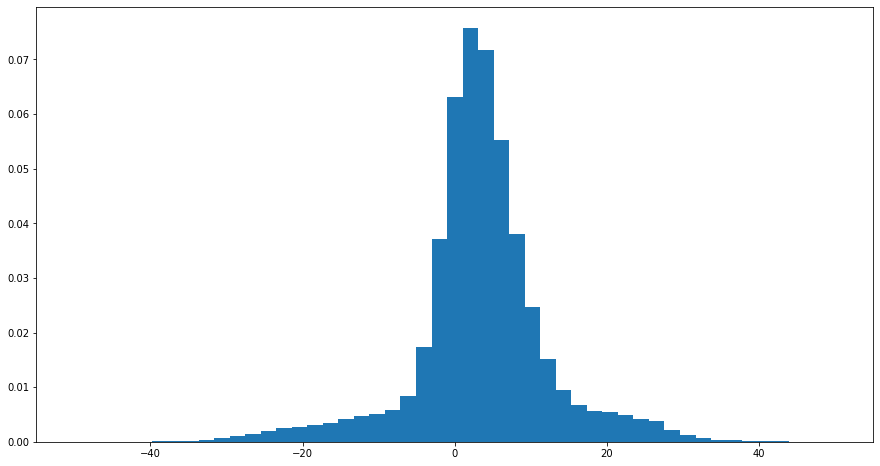

In [28]:
bias_ot=overscan_subtraction(bias,right_overscan,trimsec,'mean','hermite',2)
bins=np.linspace(-50,50,50)
_,_,_=plt.hist(bias_ot.flatten(),bins=bins,density=True)
plt.show()

### All of the different types of fits seem to produce similar results, the AIC prefers a degree of 4 for the polynomial fit. As the polynomial fit is the only fit with an easy to define occam penalty, I'll go with a polynomial fit with degree 4

# 7) 
Combine the bias frames into a master bias frame using CCDPROC.COMBINE. By visual inspection or using image statistics, decide whether it is appropriate to combine all your bias exposures to make 1 master bias, or whether you need to restrict the input frames because of variations among your bias frames. Are there trends in your sequence of bias frames? Does either the level, or the pattern of the bias change throughout the night? If so, by how much? How much noise would you be adding to your data if you decide to do a bias subtraction in addition to your overscan subtraction. Do the subtraction of your master bias from all other science frames if you can justify that it is warranted.

#### Decide whether it is appropriate to combine all your bias exposures to make 1 master bias, or whether you need to restrict the input frames

a093.fits mean=665.8
a093.fits sigma=9.5
a094.fits mean=665.5
a094.fits sigma=8.9
a095.fits mean=665.6
a095.fits sigma=8.9
a096.fits mean=665.7
a096.fits sigma=8.9
a097.fits mean=665.7
a097.fits sigma=9.2
a098.fits mean=665.6
a098.fits sigma=8.9
a099.fits mean=665.6
a099.fits sigma=8.9
a100.fits mean=665.6
a100.fits sigma=8.9
a101.fits mean=665.6
a101.fits sigma=8.9
a102.fits mean=665.5
a102.fits sigma=9.1
a103.fits mean=665.6
a103.fits sigma=9.2
a104.fits mean=665.6
a104.fits sigma=8.9
a105.fits mean=665.5
a105.fits sigma=8.9
a106.fits mean=665.6
a106.fits sigma=9.2
a107.fits mean=665.5
a107.fits sigma=9.0
a108.fits mean=665.6
a108.fits sigma=9.0
a109.fits mean=665.6
a109.fits sigma=8.9
a110.fits mean=665.6
a110.fits sigma=8.9
a111.fits mean=665.6
a111.fits sigma=8.9


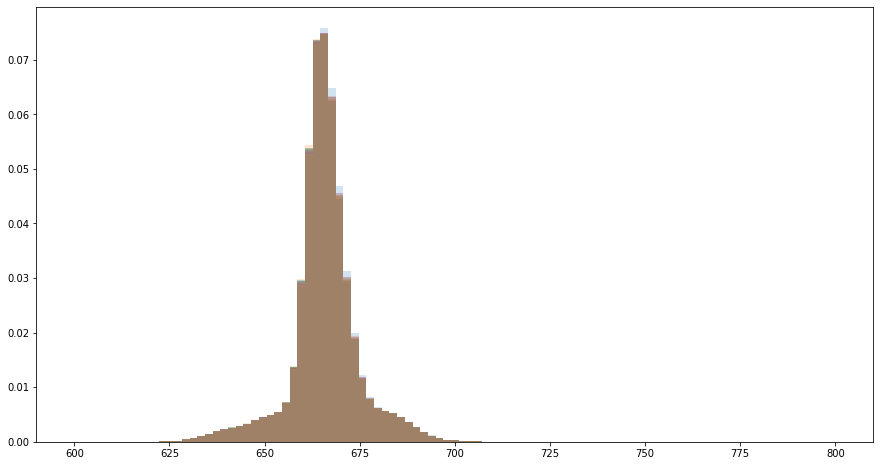

In [29]:
# Does the level change throughout the night?
bins=np.linspace(600,800,100)
for name in biasnames:
    bias_iter=fits.open(imagedir+name)[0].data
    plt.hist(np.asarray(bias_iter).flatten(),bins=bins,density=True,alpha=0.2)
    
    print('{:s} mean={:.1f}'.format(name,np.mean(bias_iter.flatten())))
    print('{:s} sigma={:.1f}'.format(name,np.std(bias_iter.flatten())))
    

### The level of bias images does not change throughout the night


In [30]:
bias_images=np.zeros((bias.shape[0],bias.shape[1],len(biasnames)))
for i in range(len(biasnames)):
    name=biasnames[i]
    bias_iter=fits.open(imagedir+name)[0].data
    
    bias_images[:,:,i]=bias_iter

In [31]:
# Does the pattern of bias images change throughout the night?

# Let's look at the maximum difference between bias images at each pixel

def maxDiff(a):
    vmin = a[0]
    dmax = 0
    for i in range(len(a)):
        if (a[i] < vmin):
            vmin = a[i]
        elif (a[i] - vmin > dmax):
            dmax = a[i] - vmin
    return dmax

nrows=bias.shape[0]
ncols=bias.shape[1]
maxdiff_image=np.zeros((nrows,ncols))
for row in range(nrows):
    for column in range(ncols):
        
        vals=bias_images[row,column,:]
        maxdiff_image[row,column]=maxDiff(vals)

In [32]:
print(np.amin(maxdiff_image.flatten()))
print(np.amax(maxdiff_image.flatten()))

3.0
3096.0


Text(0, 0.5, 'Density')

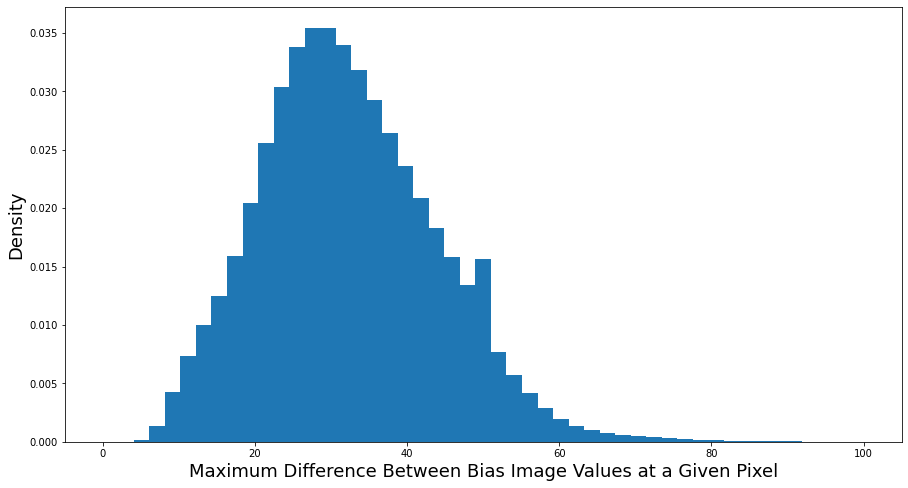

In [33]:
bins=np.linspace(0,100,50)
_,_,_=plt.hist(maxdiff_image.flatten(),bins=bins,density=True)
plt.xlabel('Maximum Difference Between Bias Image Values at a Given Pixel',fontsize=18)
plt.ylabel('Density',fontsize=18)

Text(0.5, 1.0, 'Maximum Difference Between Bias Image Values at a Given Pixel')

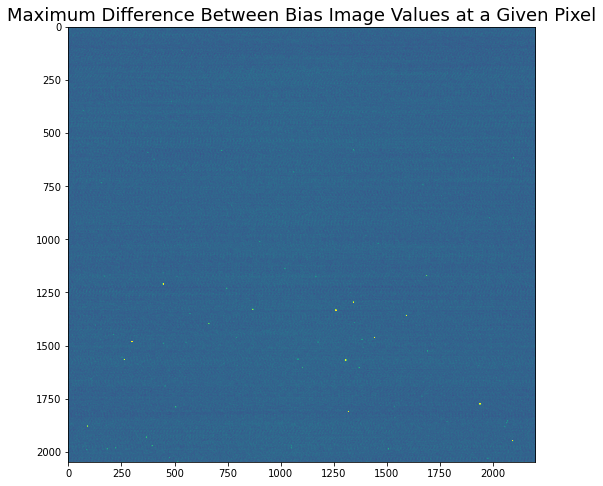

In [34]:
plt.imshow(maxdiff_image,vmin=0,vmax=100)
plt.title('Maximum Difference Between Bias Image Values at a Given Pixel',fontsize=18)

### There doesn't seem to be a pattern of bias images changing, just some pixels with at least 1 bad observation

### Each Bias image seems very similar, it is appropriate to combine all bias images into 1 master image

### Combine the bias frames into a master bias frame

Should we do a mean or median combine?

In [35]:
bias_images=np.zeros((bias.shape[0],bias.shape[1],len(biasnames)))
for i in range(len(biasnames)):
    name=biasnames[i]
    bias_iter=fits.open(imagedir+name)[0].data
    
    bias_images[:,:,i]=bias_iter

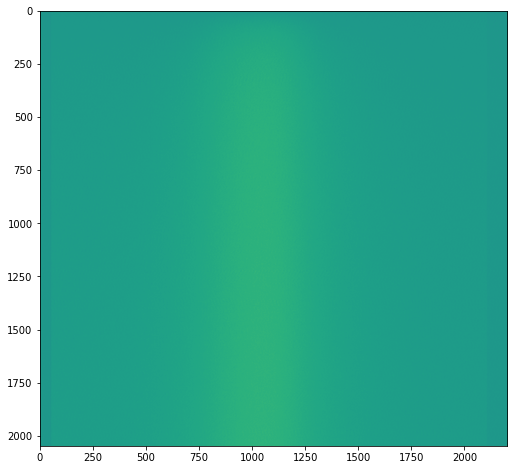

In [36]:
bias_master_median=np.median(bias_images,axis=2)
plt.imshow(bias_master_median,vmin=bias_vmin,vmax=bias_vmax)

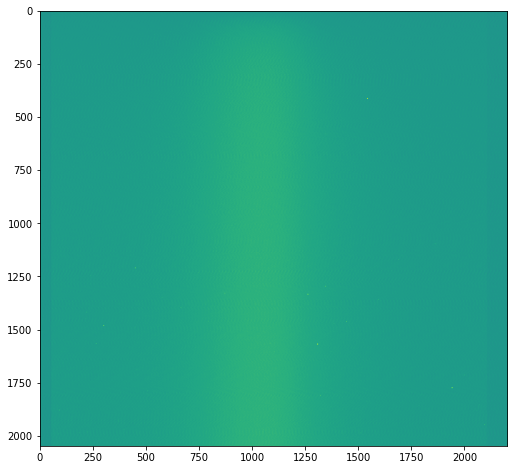

In [37]:
bias_master_mean=np.mean(bias_images,axis=2)
plt.imshow(bias_master_mean,vmin=bias_vmin,vmax=bias_vmax)

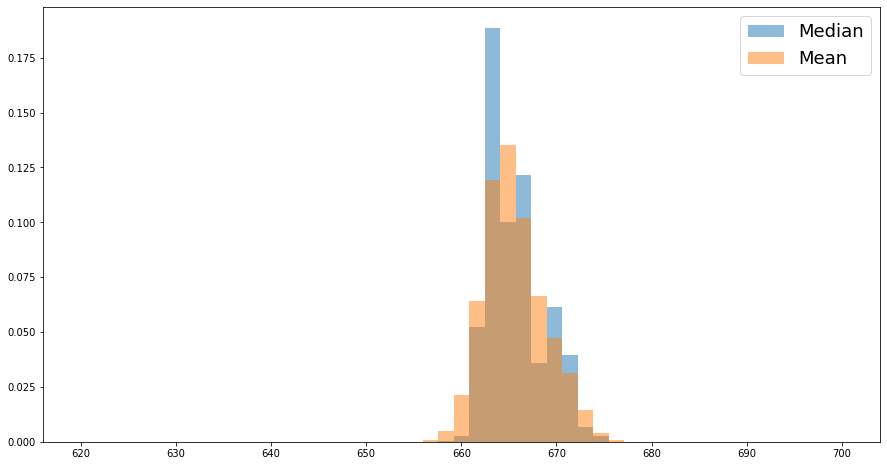

In [38]:
bins=np.linspace(bias_vmin,bias_vmax,num=50)
plt.hist(bias_master_median.flatten(),bins=bins,density=True,label='Median',alpha=0.5)
plt.hist(bias_master_mean.flatten(),bins=bins,density=True,label='Mean',alpha=0.5)
plt.legend(loc='best',fontsize=18)

### The mean looks more normally distributed

In [39]:
bias_master=bias_master_mean

#### How much noise would you be adding to your data if you decide to do a bias subtraction in addition to your overscan subtraction?

Overscan subtraction provides a row-wise normalization for a given image, the master bias provides a pattern for subtracting columns

In [40]:

flat_images=np.zeros(shape=(num_flats,num_rows,num_columns_all))
for i in range(num_flats):
    data=fits.open(imagedir+flatnames[i])[0].data
    flat_images[i,:,:]=data
    
science_images=np.zeros(shape=(num_science,num_rows,num_columns_all))
for i in range(num_science):
    data=fits.open(imagedir+sciencenames[i])[0].data
    science_images[i,:,:]=data
    

In [41]:
def overscan_subtraction(images,trim,overscan,combine_method='mean',fit_deg=3):
    '''
    performs an overscan subtraction on a stack of images and trims the output
    
    params:
        images - num_images,num_rows,num_columns
        trim - list of length 2 with first and last column of trimsec
        overscane - list of length 2 with first and last column of overscan
        combine_method - method for collapsing columns of overscan region, 'mean' or 'median'
        fit_deg - degree of row-wise polynomial fit of overscan region
        
    returns:
        images_ot - stack of images with overscan subtraction performed and overscan regions trimmed off
    '''
    num_images=images.shape[0]
    num_rows=images.shape[1]
    num_columns_all=images.shape[2]
    num_columns_trim=trim[1]-trim[0]
    
    images_ot=np.zeros(shape=(num_images,num_rows,num_columns_trim))
    
    for i in range(num_images):
        
        image_overscan=images[i,:,overscan[0]:overscan[1]]
        
        # Collapse the columns of the overscan region using mean or median
        if combine_method=='mean':
            combine_overscan=np.mean(image_overscan,axis=1)
        elif combine_method=='median':
            combine_overscan=np.median(image_overscan,axis=1)
            
        rows=np.arange(len(combine_overscan))
        
        # perform a polynomial fit across rows of the combined overscan
        p=np.flip(np.polyfit(x=rows,y=combine_overscan,deg=fit_deg)) #flipped so 0 order term is first
        beta=p.reshape((len(p),1)) # make a column matrix
        
        # Now create design matrix
        X=np.zeros((len(rows),fit_deg+1))
        for column in range(X.shape[1]):
            X[:,column]=rows**column
            
        # do some matrix multiplication to get the fit
        fit=np.matmul(X,beta).flatten() # flattened so output is not a column matrix
        
        # now subtract out fit row-wise
        image_subtract=np.zeros((num_rows,num_columns_all))
        for row in range(len(rows)):
            image_subtract[row,:]=images[i,row,:]-fit[row]
            
        # finally trim off overscan
        image_sub_trim=image_subtract[:,trim[0]:trim[1]]
        
        images_ot[i,:,:]=image_sub_trim
        
        
    return images_ot
    
def overscan_and_master_bias_subtraction(images,bias,trim,overscan,combine_method='mean',fit_deg=3):
    '''
    performs and overscan and a master bias subtraction on a stack of images and trims the output
    
    params:
        images - num_images,num_rows,num_columns
        bias - master bias image (shape num_rows,num_columns)
        trim - list of length 2 with first and last column of trimsec
        overscane - list of length 2 with first and last column of overscan
        combine_method - method for collapsing columns of overscan region, 'mean' or 'median'
        fit_deg - degree of row-wise polynomial fit of overscan region
    returns:
        images_obt - stack of images with overscan and bias subtraction performed and overscan regions trimmed off
        
    '''
    num_images=images.shape[0]
    num_rows=images.shape[1]
    num_columns_all=images.shape[2]
    num_columns_trim=trim[1]-trim[0]
    
    images_obt=np.zeros(shape=(num_images,num_rows,num_columns_trim))
    
    for i in range(num_images):
        
        image_overscan=images[i,:,overscan[0]:overscan[1]]
        
        # Collapse the columns of the overscan region using mean or median
        if combine_method=='mean':
            combine_overscan=np.mean(image_overscan,axis=1)
        elif combine_method=='median':
            combine_overscan=np.median(image_overscan,axis=1)
            
        rows=np.arange(len(combine_overscan))
        
        # perform a polynomial fit across rows of the combined overscan
        p=np.flip(np.polyfit(x=rows,y=combine_overscan,deg=fit_deg)) #flipped so 0 order term is first
        beta=p.reshape((len(p),1)) # make a column matrix
        
        # Now create design matrix
        X=np.zeros((len(rows),fit_deg+1))
        for column in range(X.shape[1]):
            X[:,column]=rows**column
            
        # do some matrix multiplication to get the fit
        fit=np.matmul(X,beta).flatten() # flattened so output is not a column matrix
        # this is the expected bias value of each row from the overscan region
        
        # For each row of master bias image, multiple master bias values so that the mean
        # of the master bias for that row is equal to the overscan fit of that row
        
        bias_norm=np.zeros(shape=(num_rows,num_columns_all))
        for row in range(num_rows):
            norm_factor=fit[row]/np.mean(bias[row,trim[0]:trim[1]])
            bias_norm[row,:]=bias[row,:]*norm_factor
        
        
        # Then subtract normalized master bias from the image
        image_subtract=images[i,:,:]-bias_norm
        
        # Finally trim off overscan
        image_sub_trim=image_subtract[:,trim[0]:trim[1]]
        
        images_obt[i,:,:]=image_sub_trim
        
    return images_obt
        
        
    
science_images_ot=overscan_subtraction(science_images,trimsec,right_overscan)
flat_images_ot=overscan_subtraction(flat_images,trimsec,right_overscan)

science_images_obt=overscan_and_master_bias_subtraction(science_images,bias_master,trimsec,right_overscan)
flat_images_obt=overscan_and_master_bias_subtraction(flat_images,bias_master,trimsec,right_overscan)



In [42]:
for i in range(num_science):
    ot_std=np.std(science_images_ot[i,:,:].flatten())
    obt_std=np.std(science_images_obt[i,:,:].flatten())
    
    print('Science Image {:.0f}, overscan subtraction std dev: {:.1f}'.format(i,ot_std))
    print('Science Image {:.0f}, overscan and master bias subtraction std dev: {:.1f}'.format(i,obt_std))

Science Image 0, overscan subtraction std dev: 2265.5
Science Image 0, overscan and master bias subtraction std dev: 2264.2
Science Image 1, overscan subtraction std dev: 2103.6
Science Image 1, overscan and master bias subtraction std dev: 2102.3
Science Image 2, overscan subtraction std dev: 1945.7
Science Image 2, overscan and master bias subtraction std dev: 1944.5
Science Image 3, overscan subtraction std dev: 1789.3
Science Image 3, overscan and master bias subtraction std dev: 1788.1
Science Image 4, overscan subtraction std dev: 2094.3
Science Image 4, overscan and master bias subtraction std dev: 2093.1
Science Image 5, overscan subtraction std dev: 1907.1
Science Image 5, overscan and master bias subtraction std dev: 1905.9
Science Image 6, overscan subtraction std dev: 1758.4
Science Image 6, overscan and master bias subtraction std dev: 1757.3
Science Image 7, overscan subtraction std dev: 1608.6
Science Image 7, overscan and master bias subtraction std dev: 1607.5
Science 

In [43]:
mean_raw_trim=np.mean(science_images[0,:,trimsec[0]:trimsec[1]].flatten())
mean_raw_overscan=np.mean(science_images[0,:,right_overscan[0]:right_overscan[1]].flatten())
mean_ot=np.mean(science_images_ot[0,:,:].flatten())
mean_obt=np.mean(science_images_obt[0,:,:].flatten())

print('Mean Value for Raw Science Image in TrimSec: {:.3f}'.format(mean_raw_trim))
print('Mean Value for Raw Science Image in Overscan: {:.3f}'.format(mean_raw_overscan))
print('Mean Value for Overscan Subtracted Science Image: {:.3f}'.format(mean_ot))
print('Mean Value for Overscan and Master Bias Subtracted Science Image: {:.3f}'.format(mean_obt))

Mean Value for Raw Science Image in TrimSec: 48049.511
Mean Value for Raw Science Image in Overscan: 1158.082
Mean Value for Overscan Subtracted Science Image: 46891.429
Mean Value for Overscan and Master Bias Subtracted Science Image: 46891.429


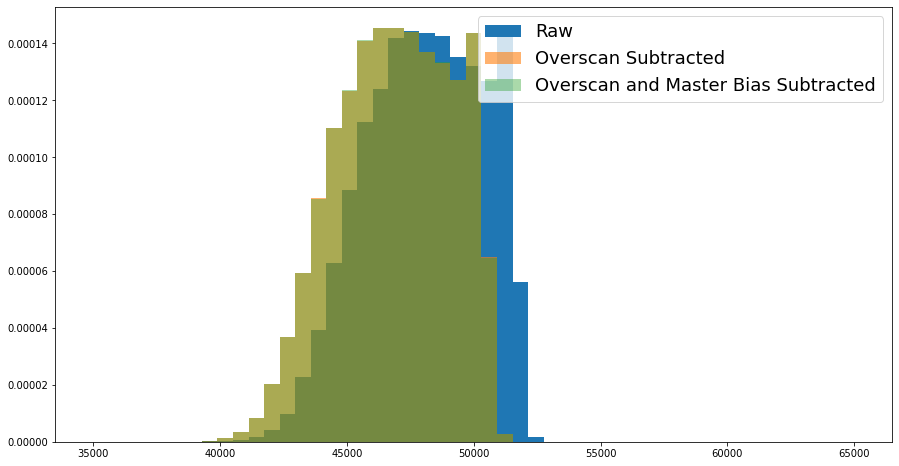

In [44]:
bins=np.linspace(35000,65000,50)
_,_,_=plt.hist(science_images[0,:,:].flatten(),bins=bins,density=True,label='Raw')
_,_,_=plt.hist(science_images_ot[0,:,:].flatten(),bins=bins,density=True,alpha=0.6,label='Overscan Subtracted')
_,_,_=plt.hist(science_images_obt[0,:,:].flatten(),bins=bins,density=True,alpha=0.4,label='Overscan and Master Bias Subtracted')
plt.legend(loc='best',fontsize=18)

### Including the Master Bias Subtraction in your Overscan subtraction very slightly decreases the standard deviations of the images, so we might as well do it.

### Do the subtraction of your master bias from all other science frames if you can justify that it is warranted.

In [45]:
science_images_obt=overscan_and_master_bias_subtraction(science_images,bias_master,trimsec,right_overscan)

# 8)

Now examine the ‘dark’ images quantitatively and estimate the range of dark current (electrons per pixel per second) you see in the darks. WIRO Prime’s gain is 2.5 e−/ADU. Use either Python to inspect the header and see the exposure time in each of the darks.
Pixels will vary! Be careful to avoid being fooled by cosmic rays, which will appear as large bright spots usually spread over a few pixels, whereas high dark current is usually isolated to just individual pixels.

In [46]:
dark_images=np.zeros(shape=(num_darks,num_rows,num_columns_all))
exposure_times=[]
for i in range(num_darks):
    dark=fits.open(imagedir+darknames[i])[0]
    exposure_times.append(dark.header['EXPTIME'])
    print(dark.header['EXPTIME'])
    data=dark.data
    dark_images[i,:,:]=data

2
2
2
2
2
5
5
5
5
5
300
300
300
300
300


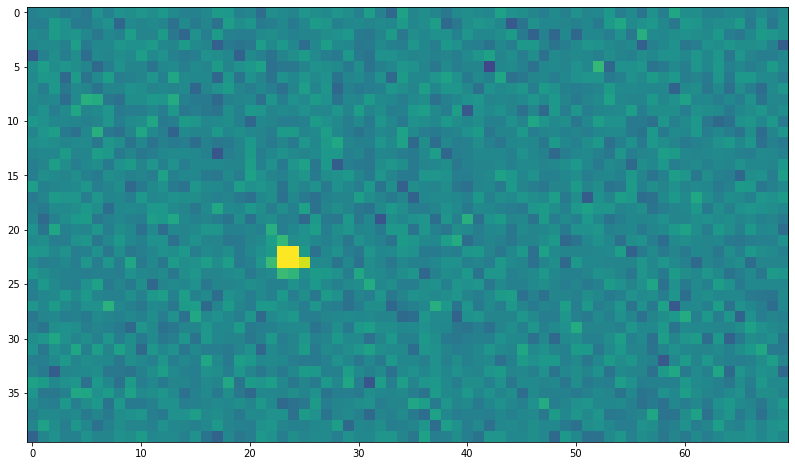

In [47]:
plt.imshow(dark_images[0,1530:1570,400:470],vmin=dark_vmin,vmax=dark_vmax)
# Here's a cosmic ray

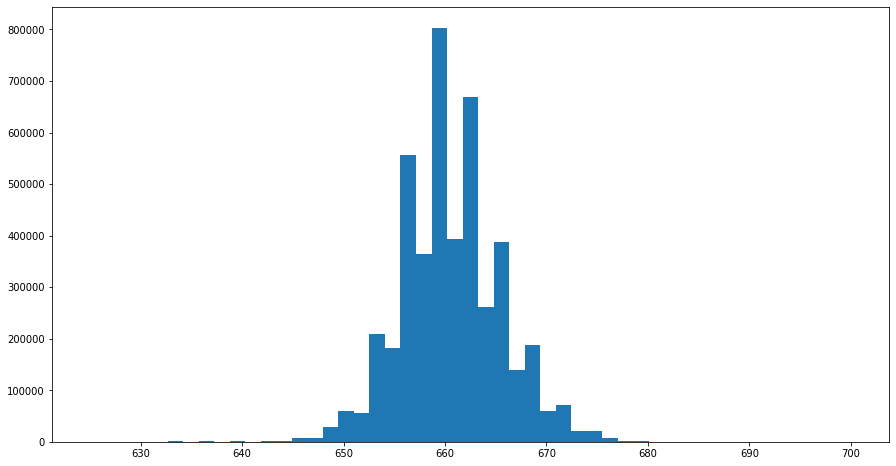

In [48]:
bins=np.linspace(dark_vmin,dark_vmax,50)
_,_,_=plt.hist(dark_images[0,:,:].flatten(),bins=bins)

In [49]:
gain=2.5 #e- ADU^-1

dark_current_images=np.zeros(shape=(num_darks,num_rows,num_columns_all))
for i in range(num_darks):
    dark_current_images[i,:,:]=dark_images[i,:,:]*gain/exposure_times[i]

Text(0, 0.5, 'Density')

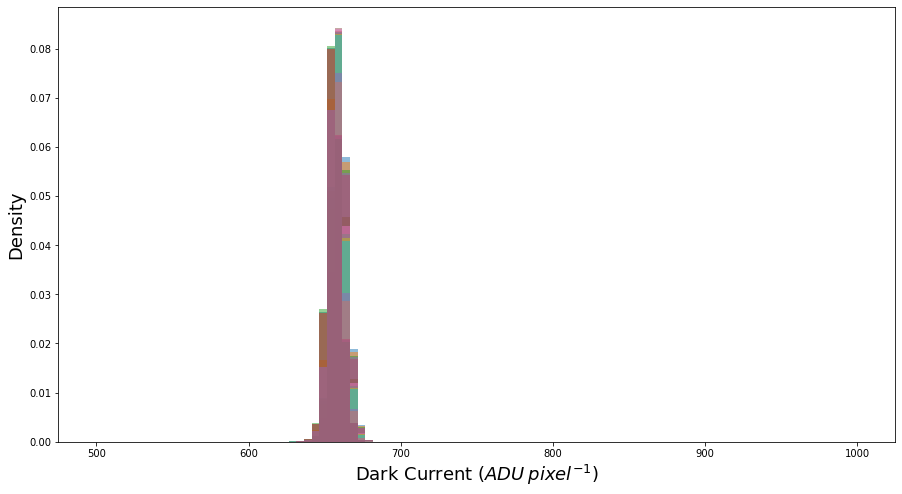

In [50]:
bins=np.linspace(500,1000,100)
for i in range(num_darks):
    _,_,_=plt.hist(dark_images[i,:,:].flatten(),bins=bins,density=True,alpha=0.5)
plt.xlabel(r'Dark Current ($ADU \: pixel^{-1}$)',fontsize=18)
plt.ylabel('Density',fontsize=18)

Text(0, 0.5, 'Density')

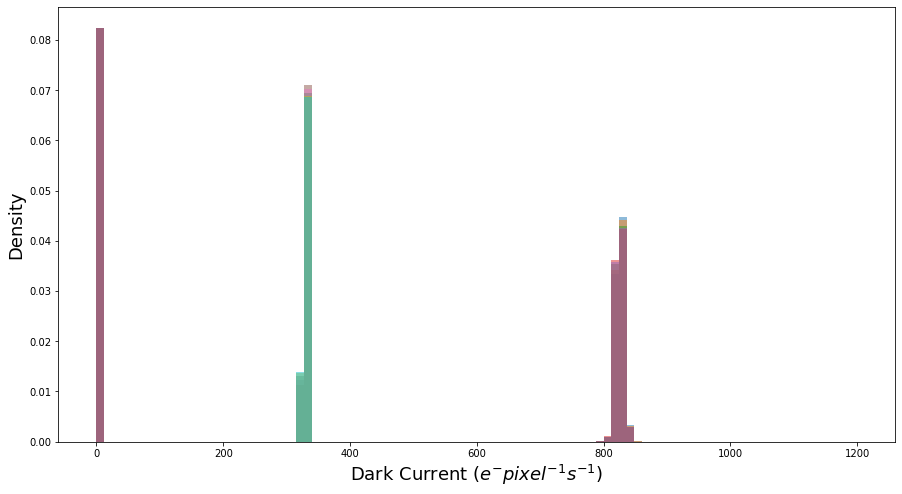

In [51]:
bins=np.linspace(0,1200,100)
for i in range(num_darks):
    _,_,_=plt.hist(dark_current_images[i,:,:].flatten(),bins=bins,density=True,alpha=0.5)
    
plt.xlabel('Dark Current ($e^{-} pixel^{-1} s^{-1}$)',fontsize=18)
plt.ylabel('Density',fontsize=18)

# 9)

Use CCDPROC.COMBINE to combine darks together to make a master dark. You will need to play with different combination parameters to see which one does the best job of eliminating cosmic rays. At a minimum, do

- A straight average of all dark frames.
- A straight median of all dark frames.
- An average where outlier pixels are rejected if they are more than 3σ away from the mean.
- A median where outlier pixels are rejected if they are more than 3σ away from the mean.

Use the resulting RMS in the master image as an indicator of which combination procedure is best. Compare your master dark to your master bias to estimate the significance of the highest dark count pixels. How many times larger is the typical dark current than the noise (σ) in the master image?

In [52]:
    
def sigma_clip(images,method='mean',sigma_reject=2,max_iter=3):
    '''
    for each pixel, iteratively clip values that are more than N sigma away from the mean or median value 
    for that pixel across all images

    params:
        images - num_images,num_rows,num_columns
        method - method for estimating the central value for sigma clipping, 'mean', or 'median'
        sigma_reject - sigma multiplier for clipping
        max_iter - maximum number of passes through the images for convergence
    returns:
        clipped_images
        mask - same shape as clipped_images, is False if this location is clipped, is True if not clipped
    '''
    num_images=np.shape(images)[0]
    num_rows=np.shape(images)[1]
    num_columns=np.shape(images)[2]
    

    clipped_images=images
    mask=np.array(np.ones(shape=(num_images,num_rows,num_columns)),dtype=bool)

    converged=False
    count=0
    while not converged:
        count+=1
        print('Starting Sigma-Clip Iteration '+str(count))

        new_clip=False # has the clipping algorithm clipped a point this pass?

        for i in range(num_rows):
            for j in range(num_columns):

                pixel_values=clipped_images[:,i,j] # values at this pixel across all images

                if method=='mean':
                    central_value=np.mean(pixel_values[mask[:,i,j]])
                elif method=='median':
                    central_value=np.median(pixel_values[mask[:,i,j]])

                sigma=np.std(pixel_values[mask[:,i,j]])
                distance=np.absolute(pixel_values-central_value) # distance from central value at each image

                mask_clip=np.where(distance>sigma*sigma_reject,True,False) # True if this index needs to be clipped

                #if np.count_nonzero(mask_clip)>0:
                    #print(mask_clip)

                mask_clip_new=np.logical_and(mask_clip,mask[:,i,j]) # true if this index needs to be clipped and is not already clipped
                if np.count_nonzero(mask_clip_new)>0:
                    #print('Clipped {:.0f} images of pixel {:.0f},{:.0f}'.format(np.count_nonzero(mask_clip_new),i,j))

                    new_clip=True
                    mask[mask_clip_new,i,j]=False
                    clipped_images[mask_clip_new,i,j]=0


        if ((not new_clip) or (count>=max_iter)):
            # If the clipping algorithm has not clipped any points this pass, it has converged
            converged=True
            
    num_kept=np.sum(mask)
    num_total=num_images*num_rows*num_columns
    num_clipped=num_total-num_kept
    
    print("Clipped {:.2f} percent of pixels".format(100*num_clipped/num_total))

    return clipped_images,mask


def combine_images(images,method,mask=None):
    '''
    combines a stack of images into a master image
    
    params:
        images - num_images,num_rows,num_columns, if mask is not None, sigma clipped images, 
        else images without sigma clipping
        method - method for combining images, 'mean' or 'median'
        mask - if images is sigma-clipped this is a 3D array of the same shape as images, 
        is True if that pixel is included, False if it is clipped
    '''
    num_images=images.shape[0]
    num_rows=images.shape[1]
    num_columns=images.shape[2]
    
    if mask is None:
        if method=='mean':
            master_image=np.mean(images,axis=0)
        elif method=='median':
            master_image=np.median(images,axis=0)
            
        return master_image

        
    master_image=np.zeros(shape=(num_rows,num_columns))
        
    for row in range(num_rows):
        for column in range(num_columns):
            
            if method=='mean':
                center=np.mean(images[:,row,column][mask[:,row,column]])
            elif method=='median':
                center=np.median(images[:,row,column][mask[:,row,column]])
            
            master_image[row,column]=center
        
    return master_image   
 

In [53]:
# NOTE this cell is expensive

print('Creating Mean Master Image')
master_dark_mean=combine_images(dark_images,method='mean')
print('Creating Median Master Image')
master_dark_median=combine_images(dark_images,method='median')
clipped_dark_images,mask=sigma_clip(dark_images,sigma_reject=2)
print('Creating Mean Sigma Clipped Master Image')
master_dark_mean_clip=combine_images(clipped_dark_images,method='mean',mask=mask)
print('Creating Median Sigma Clipped Master Image')
master_dark_median_clip=combine_images(clipped_dark_images,method='median',mask=mask)

Creating Mean Master Image
Creating Median Master Image
Starting Sigma-Clip Iteration 1
Starting Sigma-Clip Iteration 2
Starting Sigma-Clip Iteration 3
Clipped 7.35 percent of pixels
Creating Mean Sigma Clipped Master Image
Creating Median Sigma Clipped Master Image


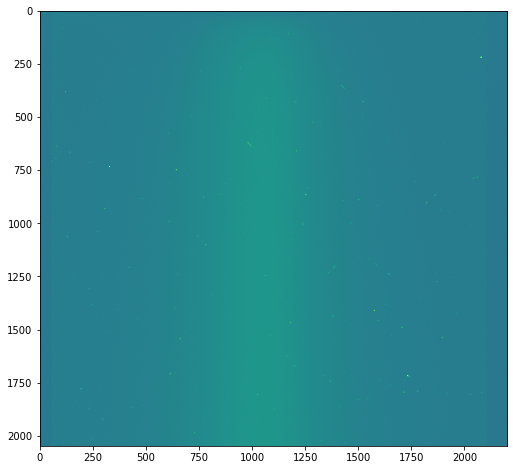

In [54]:
plt.imshow(master_dark_mean,vmin=dark_vmin,vmax=dark_vmax)

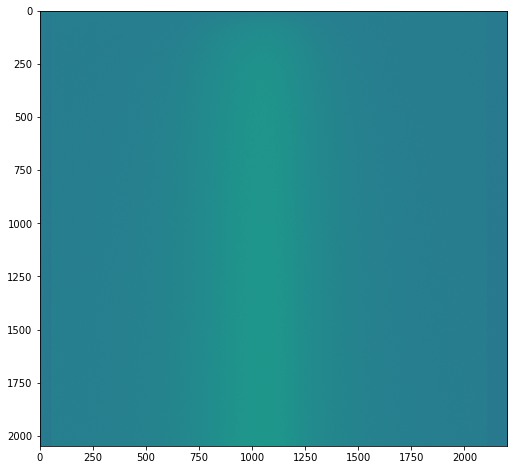

In [55]:
plt.imshow(master_dark_median,vmin=dark_vmin,vmax=dark_vmax)

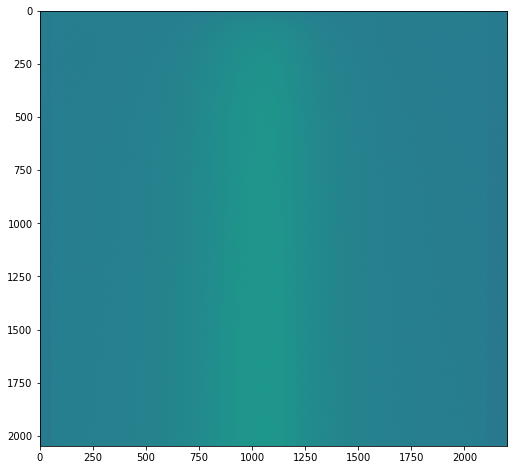

In [56]:
plt.imshow(master_dark_mean_clip,vmin=dark_vmin,vmax=dark_vmax)

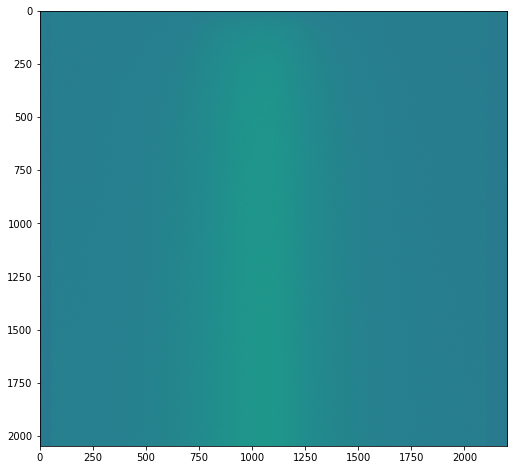

In [57]:
plt.imshow(master_dark_median_clip,vmin=dark_vmin,vmax=dark_vmax)

Text(0, 0.5, 'Density')

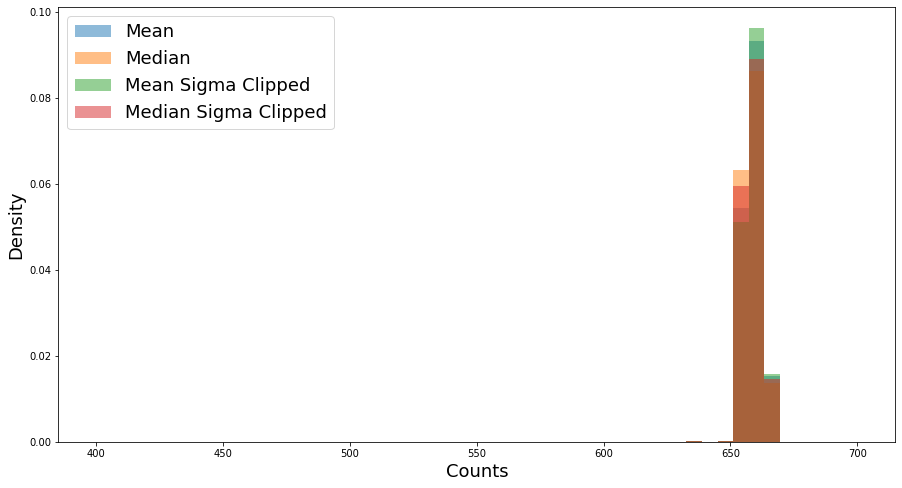

In [58]:
bins=np.linspace(400,700,50)
plt.hist(master_dark_mean.flatten(),bins=bins,alpha=0.5,density=True,label='Mean')
plt.hist(master_dark_median.flatten(),bins=bins,alpha=0.5,density=True,label='Median')
plt.hist(master_dark_mean_clip.flatten(),bins=bins,alpha=0.5,density=True,label='Mean Sigma Clipped')
plt.hist(master_dark_median_clip.flatten(),bins=bins,alpha=0.5,density=True,label='Median Sigma Clipped')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Counts',fontsize=18)
plt.ylabel('Density',fontsize=18)

In [59]:
print('Mean Combine std dev: {:.2f}'.format(np.std(master_dark_mean.flatten())))
print('Median Combine std dev: {:.2f}'.format(np.std(master_dark_median.flatten())))
print('Mean Combine 2 sigma-clip std dev: {:.2f}'.format(np.std(master_dark_mean_clip.flatten())))
print('Median Combine 2 sigma-clip std dev: {:.2f}'.format(np.std(master_dark_median_clip.flatten())))

Mean Combine std dev: 3.08
Median Combine std dev: 2.92
Mean Combine 2 sigma-clip std dev: 2.87
Median Combine 2 sigma-clip std dev: 2.95


### The median combined images are best because they're not pulled by outliers

Compare your master dark to your master bias to estimate the significance of the highest dark count pixels. How many times larger is the typical dark current than the noise (σ) in the master image?

Text(0, 0.5, 'Density')

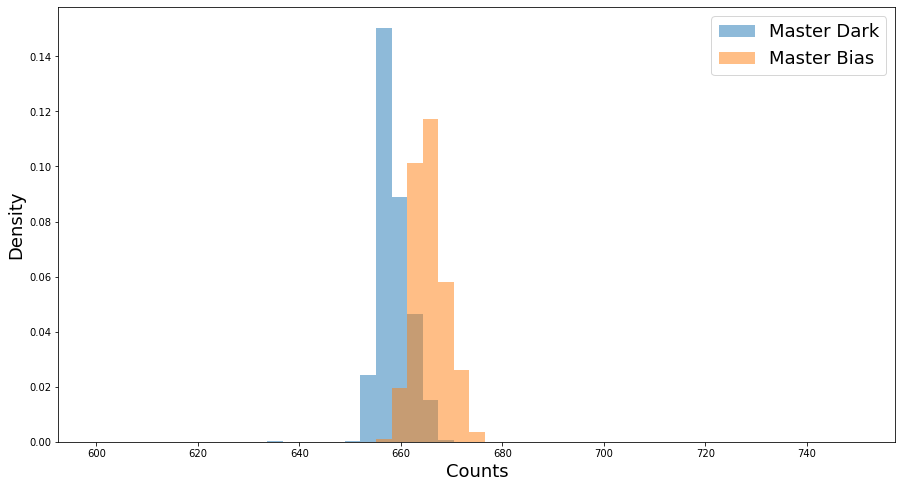

In [60]:
bins=np.linspace(600,750,50)
plt.hist(master_dark_median_clip.flatten(),bins=bins,density=True,alpha=0.5,label='Master Dark')
plt.hist(bias_master.flatten(),bins=bins,density=True,alpha=0.5,label='Master Bias')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Counts',fontsize=18)
plt.ylabel('Density',fontsize=18)

# The bias and dark values are comparable, with the bias counts being slightly higher

In [61]:
print(np.mean(master_dark_median_clip.flatten()))
print(np.std(master_dark_median_clip.flatten()))
# The dark current is many times larger than the standard deviation of the master image

658.7720668723366
2.947936742064192
